# 20260126 space_titanic

In [ ]:
'''
Created on 2026. 1. 26.

@author: chaliepark
'''
import numpy as np
import pandas as pd
from os.path import join   
from moduSource.print_supprt import print_all
from sklearn.decomposition import PCA  
import xgboost as xboost
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from moduSource.csv import save_submission
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm.sklearn as lg 

#글로벌변수
DATA_DIR='~/work/kaggle_kakr_housing/data'
LEARNING_PARAM=0.8

def save_submission(models, train, y, test, model_name,return_column_name, rmsle=None,data_dir):
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    if type(models) == dict:
        AveragingBlendingForGridCv(models,train,y,test)
        submission[return_column_name]= np.mean(models['prediction']) 
    else:
        models.fit(train, y)
        prediction = models.predict(test)
        submission[return_column_name]=prediction
    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

def AveragingBlendingForGridCv(models, x, y, sub_x):
    model_len=len(models['model'])
    for i in range(model_len):
        print(models['model'][i].__class__.__name__)
        models['model'][i].fit(x.values,y.values)
        models['prediction'].append(models['model'][i].predict(sub_x))
        
        models['param'].append(models['model'][i].cv_results_['params'])
        models['score'].append(models['model'][i].cv_results_['mean_test_score'])
        models['result']['dataframe'].append(pd.DataFrame(models['param'][i]))
        models['result']['RMSLE'].append(np.sqrt(-1 * models['score'][i]))



train_df = pd.read_csv(join(DATA_DIR,'train.csv'))
test_df = pd.read_csv(join(DATA_DIR,'test.csv'))


data=pd.concat((train_df,test_df),axis=0)

print_all()
print(len(data))
print(data.info())
print(data.describe())
print(data.head())




train 데이터,test 데이터를 합쳤을떄 전체 데이터 길이:12970  
하기와 같이 결측되버린 데이터가 많이 있다.  
     Column        Non-Null Count  Dtype    
---  ------        --------------  -----    
1   HomePlanet    12682 non-null  object  
2   CryoSleep     12660 non-null  object  
3   Cabin         12671 non-null  object  
4   Destination   12696 non-null  object   
5   Age           12700 non-null  float64  
6   VIP           12674 non-null  object  
7   RoomService   12707 non-null  float64  
8   FoodCourt     12681 non-null  float64  
9   ShoppingMall  12664 non-null  float64  
10  Spa           12686 non-null  float64  
11  VRDeck        12702 non-null  float64  
12  Name          12676 non-null  object  

In [ ]:

#데이터전처리 
data['CryoSleep'] = data['CryoSleep'].fillna(False) 
data['VIP'] = data['VIP'].fillna(False)
data['HomePlanet'] = data['HomePlanet'].fillna(data['HomePlanet'].mode()[0])
data['Cabin'] = data['Cabin'].fillna(data['Cabin'].mode()[0])
data['Destination'] = data['Destination'].fillna(data['Destination'].mode()[0])
data['Age'] = data['Age'].fillna(data['Age'].mode()[0])
data['RoomService'] = data['RoomService'].fillna(data['RoomService'].mode()[0])
data['FoodCourt'] = data['FoodCourt'].fillna(data['FoodCourt'].mode()[0])
data['ShoppingMall'] = data['ShoppingMall'].fillna(data['ShoppingMall'].mode()[0])
data['Spa'] = data['Spa'].fillna(data['Spa'].mode()[0])
data['VRDeck'] = data['VRDeck'].fillna(data['VRDeck'].mode()[0])
data['Name'] = data['Name'].fillna(data['Name'].mode()[0])

train_len=len(train_df)
print('#train_len:'+str(train_len))
print('');y = train_df['Transported']
del data['Transported'];

cab = data['Cabin'].apply(lambda w: w.split('/'))
data['Cabin1'] = cab.apply(lambda i: i[0])
data['Cabin2'] = cab.apply(lambda i: int(i[1]))
data['Cabin3'] = cab.apply(lambda i: i[2])

print(sum(data['Cabin2']))
del data['Cabin']


print(train_df[['CryoSleep','Transported']].groupby(['CryoSleep'], as_index = False).mean().sort_values(by = 'Transported'))
print(train_df[['HomePlanet', 'Transported']].groupby(['HomePlanet'], as_index = False).mean().sort_values(by='Transported'))
print(train_df[['Destination', 'Transported']].groupby(['Destination'], as_index = False).mean().sort_values(by = 'Transported'))


- CryoSleep/Transported  
  CryoSleep  Transported  
0     False     0.328921  
1      True     0.817583  
CryoSleep하지않은 사람일수록 Transported를하지않은 사람일가능성이 크다  
  
- HomePlanet/Transported  
  HomePlanet  Transported  
0      Earth     0.423946  
2       Mars     0.523024  
1     Europa     0.658846  
Transported==0(not_arrived)인 데이터중에서 대부분이 Earth  
Transported==0(not_arrived)인 데이터중에서 약 20%씩Europa,Mars  
Transported==1(arrived)인 데이터중에서 22~3%의 사람만 Mars  
Transported==1(arrived)인 데이터중에서 약33%의 사람이Europa  
  
- Destination/Transported  
     Destination  Transported  
2    TRAPPIST-1e     0.471175  
1  PSO J318.5-22     0.503769  
0    55 Cancri e     0.610000  
Transported==0(not_arrived)인 데이터중TRAPPIST-1e이 압도적으로 높다  
Transported==1(arrived)인 데이터중TRAPPIST-1e이 압도적으로 높다  


20대가 압도적으로 높다,30대, 10대순이다  
연령대 분포
+----------+-------+
| Age 10%  |   770 |
| Age 20%  |   649 |
| Age 30%  |  2089 |
| Age 40%  |  1976 |
| Age 50%  |  1350 |
| Age 60%  |   893 |
| Age 70%  |   536 |
| Age 80%  |   294 |
| Age 90%  |   106 |
| Age_100% |    30 |
+----------+-------+


In [ ]:

'''
## Vip가 너무 쩍다(실데이터에서는전부0?) 
arrived = train_df[train_df['Transported'] == 1]['VIP'].value_counts()
not_arrived = train_df[train_df['Transported'] == 0]['VIP'].value_counts()

arrived = train_df[train_df['Transported'] == 1]['HomePlanet'].value_counts()
not_arrived = train_df[train_df['Transported'] == 0]['HomePlanet'].value_counts()

arrived = train_df[train_df['Transported'] == 1]['Destination'].value_counts()
not_arrived = train_df[train_df['Transported'] == 0]['Destination'].value_counts()


train_df.loc[(train_df['Age'] >= 0) & (train_df['Age'] < 10), 'Age'] = 0
train_df.loc[(train_df['Age'] >= 10) & (train_df['Age'] < 20), 'Age'] = 10
train_df.loc[(train_df['Age'] >= 20) & (train_df['Age'] < 30), 'Age'] = 20
train_df.loc[(train_df['Age'] >= 30) & (train_df['Age'] < 40), 'Age'] = 30
train_df.loc[(train_df['Age'] >= 40) & (train_df['Age'] < 50), 'Age'] = 40
train_df.loc[(train_df['Age'] >= 50) & (train_df['Age'] < 60), 'Age'] = 50
train_df.loc[(train_df['Age'] >= 60) & (train_df['Age'] < 70), 'Age'] = 60
train_df.loc[(train_df['Age'] >= 70) & (train_df['Age'] < 80), 'Age'] = 70
arrived = train_df[train_df['Transported'] == 1]['Age'].value_counts()
not_arrived = train_df[train_df['Transported'] == 0]['Age'].value_counts()

arrived = data[data['Transported'] == 1]['Cabin1'].value_counts()
not_arrived = data[data['Transported'] == 0]['Cabin31'].value_counts()

arrived = data[data['Transported'] == 1]['Cabin1'].value_counts()
not_arrived = data[data['Transported'] == 0]['Cabin1'].value_counts()

arrived = data[data['Transported'] == 1]['Cabin3'].value_counts()
not_arrived = data[data['Transported'] == 0]['Cabin3'].value_counts()
df = pd.DataFrame([arrived , not_arrived])
df.index = ['arrived', 'not_arrived']
df.plot(kind = 'bar', stacked =False, figsize = (6,4))
plt.title("Cabin3")
'''




##상관계수로그래프그리는건데 잘 안됨 
##plt.figure(figsize = (16, 12))
##x = sns.heatmap(train_df.corr(), cmap = 'Blues', linewidths = '0.1',annot = True)


## Transported가 아닌 딴 데이터를원핫인코딩 수행
del data['PassengerId']
#del data['CryoSleep']
del data['Name']
#del data['Destination']

encoding_train_data = pd.get_dummies(data)
print(encoding_train_data.columns)


##HomePlanet  
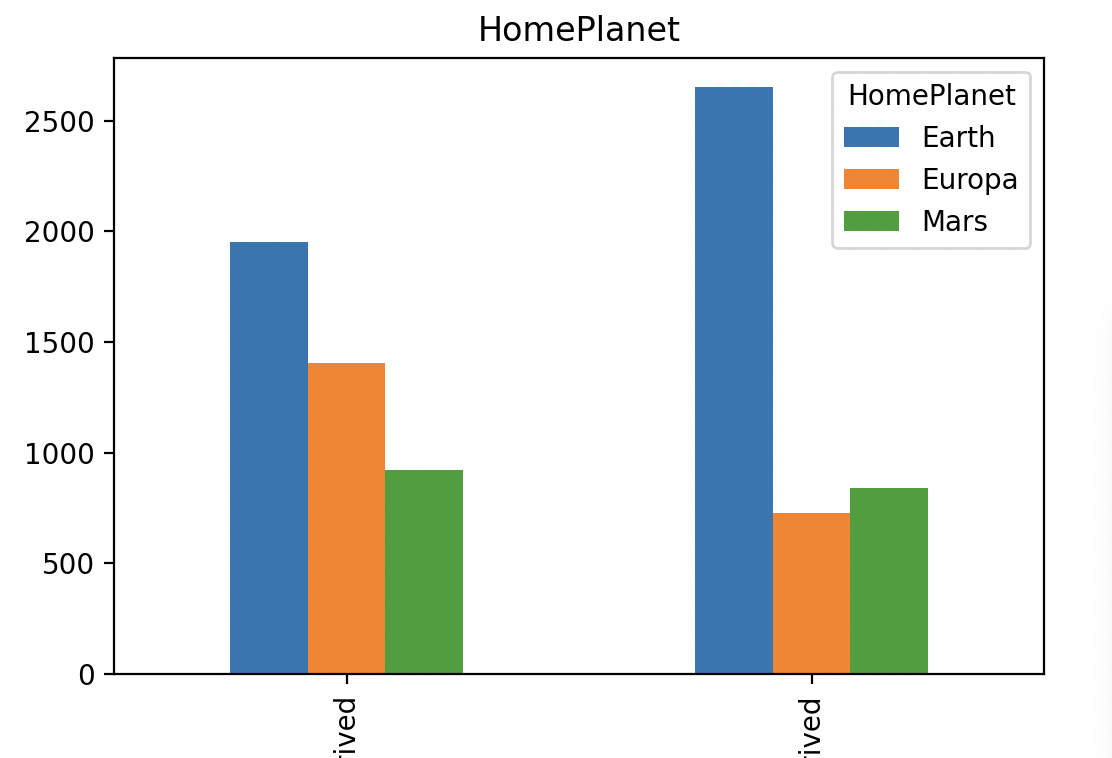  
##  

In [ ]:
'''
pairplot을 사용하여 전체적인 데이터분포를 파악한다
analysis = pd.merge(encoding_train_data,y, left_index = True, right_index = True )
sns.pairplot(analysis[['CryoSleep','Age','VIP','RoomService','FoodCourt','ShoppingMall','Transported']],hue = 'Transported', palette='husl', markers = ['o','s',])
sns.pairplot(analysis[['Spa', 'VRDeck', 'Destination_55 Cancri e', 'Destination_TRAPPIST-1e', 'Destination_PSO J318.5-22', 'Transported']],hue='Transported', palette='husl', markers=['o','s'])
sns.pairplot(analysis[['HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Cabin2','Transported']],hue = 'Transported',palette='husl',markers = ['o','s'])
sns.pairplot(analysis[['Cabin1_F',"Cabin1_G",'Cabin1_T',"Cabin3_P",'Cabin3_S',"Transported"]],hue = 'Transported', palette = 'husl', markers = ['o','s'])
plt.show()
'''

##숫자형데이터의그래프가 한쪽으로 치우쳐져서log 씌워줌
column_list = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Cabin2']
for col in column_list:
    data[col] = np.log1p(data[col].values)
    
'''
ig, ax = plt.subplots(4,3,figsize=(15, 5))
del data['PassengerId']
count=0
columns =data.columns
for a in range(4):
    for i in range(3):
        if data[columns[count]][0].dtype == np.float64 or data[columns[count]][0].dtype == int:
            print('float or int:'+columns[count])
            sns.kdeplot(data=data[columns[count]], ax=ax[a][i])
        elif data[columns[count]][0].dtype == bool:
            print('bool')
        else:
            sns.barplot(data=data[columns[count]], ax=ax[a][i])
        ax[a][i].set_title(columns[count],fontsize=12)
        count+=1
        if count == 12:
            break

'''

#X = encoding_train_data.drop(['Cabin1_A','Cabin1_G','Cabin1_T','Cabin1_D','Cabin1_C','VIP','HomePlanet_Mars','Destination_PSO J318.5-22'],axis=1)
X= encoding_train_data[:train_len];test=encoding_train_data[train_len:]

print(X.isna().sum())
y.info()
print(train_len)
print(len(y))

'''
##PCA로차원을 높여 좋은결과를낼수 있게 
pca = PCA(n_components = 10)
pca.fit(X)
pca_train_data = pca.transform(X)
pca_train_data

pca_cols = []
for i in range(0,10) :
    x = 'pca_col' + str(i)
    pca_cols.append(x)
pca_cols
pca_df = pd.DataFrame(pca_train_data, columns = pca_cols)
pca_df
'''

params = { 'n_estimators' : [ 40,45,50, 60],
            'max_depth' : [1, 2,3, 4]
         }
gboost =GridSearchCV(
            GradientBoostingRegressor(learning_rate= LEARNING_PARAM,random_state=2019),
            param_grid = params, cv = 5, n_jobs = 4,error_score='raise'
        )
xgboost =GridSearchCV(
            xboost.XGBRegressor(learning_rate= LEARNING_PARAM,random_state=2019),
            param_grid = params, cv = 5, n_jobs = 4,error_score='raise'
        )
lightgbm =GridSearchCV(
            lg.LGBMRegressor(learning_rate= LEARNING_PARAM,random_state=2019),
            param_grid = params, cv = 5, n_jobs = 4,error_score='raise'
        )



models = {'model':[xgboost,lightgbm],
          'name':['GradientBoosting','XGBoost','LightGBM'],
          'prediction':[],
          'result':{'dataframe':[],'RMSLE':[]},
          'param':[],
          'score':[]} 


#gv.fit(X.values,y.values)
##_prediction= gv.predict(test)
#print(X)

save_submission(models,X,y,test,'Transported','gradient_xgb_light',data_dir= DATA_DIR)

for i in range(len(models['model'])):
    print(models['name'][i])
    print("최적 하이퍼 파라미터 : ",models['model'][i].best_params_)
    print("최고 예측 정확도 : {:.4f}".format(models['model'][i].best_score_))